**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [2]:
ASSAY   = "LentiMPRA_K562_Nadav"
FOLDER  = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, "results", ASSAY, FOLDER)
fname = "K562.ENCSR382BVV.ENCFF348WYK.LMPRA.stranded.bed.gz"
fpath = file.path(fdiry, fname)

cnames = c(
    "Chrom_Peak", "Start_Peak", "End_Peak",
    "Chrom_Site", "Start_Site", "End_Site", "Name", "Score", "Strand",
    "Overlap"
)
dat = read_tsv(fpath, col_names = cnames)

dat_peak_score_import = dat
print(dim(dat))
head(dat)

Rows: 171405 Columns: 10
── Column specification ─────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): Chrom_Peak, Chrom_Site, Name, Strand
dbl (6): Start_Peak, End_Peak, Start_Site, End_Site, Score, Overlap

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 171405     10


Chrom_Peak,Start_Peak,End_Peak,Chrom_Site,Start_Site,End_Site,Name,Score,Strand,Overlap
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
chr1,115411,115986,chr1,115631,115831,peak1_Reversed:,0.1572,-,200
chr1,137737,139544,chr1,138940,139140,peak2_Reversed:,0.2047,-,200
chr1,137737,139544,chr1,138940,139140,peak2,-0.2317,+,200
chr1,267853,268603,chr1,267911,268111,peak4_Reversed:,-0.3220,-,200
chr1,267853,268603,chr1,267911,268111,peak4,0.4415,+,200
chr1,777949,779437,chr1,778638,778838,peak11_Reversed:,1.4364,-,200


**Check results**

In [3]:
### overlap should be all one
table(dat_peak_score_import$Overlap)


     1      2      3      4      5      6      7      8      9     10     11 
    20     23     22     18     20     18     23     20     24     20     14 
    12     13     14     15     16     17     18     19     20     21     22 
    14     20     18     14     15     12     17     20     13     23     16 
    23     24     25     26     27     28     29     30     31     32     33 
    16     24     16     23     18     25     24     29     18     30     18 
    34     35     36     37     38     39     40     41     42     43     44 
    32     24     20     20     29     27     18     21     30     22     31 
    45     46     47     48     49     50     51     52     53     54     55 
    35     21     30     18     39     37     34     28     36     30     16 
    56     57     58     59     60     61     62     63     64     65     66 
    26     27     36     32     40     43     29     48     48     41     34 
    67     68     69     70     71     72     73     74     75 

## Arrange

In [4]:
dat = dat_peak_score_import
dat = dat %>% 
    dplyr::mutate(
        Peak = paste0(Chrom_Peak, ":", Start_Peak, "-", End_Peak),
        Site = paste0(Chrom_Site, ":", Start_Site, "-", End_Site)) %>%
    dplyr::select(
        Peak, Site, Score
    )

###
dat_peak_score_arrange = dat
print(dim(dat))
head(dat)

[1] 171405      3


Peak,Site,Score
<chr>,<chr>,<dbl>
chr1:115411-115986,chr1:115631-115831,0.1572
chr1:137737-139544,chr1:138940-139140,0.2047
chr1:137737-139544,chr1:138940-139140,-0.2317
chr1:267853-268603,chr1:267911-268111,-0.3220
chr1:267853-268603,chr1:267911-268111,0.4415
chr1:777949-779437,chr1:778638-778838,1.4364


## Summary

In [5]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))
table(dat$Sign)


  neg   pos 
75480 95925 

In [6]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))

###
dat_sum_total = dat %>%
    dplyr::group_by(Peak) %>%
    dplyr::summarise(
        Mean    = mean(Score),
        Median  = median(Score),
        Max     = max(Score),
        Min     = min(Score),
        Count   = n(),
        .groups = "drop"
    )

###
dat_sum_sign = dat %>%
    dplyr::group_by(Peak, Sign) %>%
    dplyr::summarise(Mean = mean(Score), .groups = "drop") %>% 
    dplyr::mutate(Sign = dplyr::recode(Sign, `pos` = "Mean_Pos", `neg` = "Mean_Neg")) %>% 
    tidyr::spread(Sign, Mean)

###
dat = dplyr::left_join(
    dat_sum_total,
    dat_sum_sign,
    by = c("Peak")) %>% 
    replace(is.na(.), 0)

dat_peak_score_summary = dat
print(dim(dat))
head(dat)

[1] 68641     8


Peak,Mean,Median,Max,Min,Count,Mean_Neg,Mean_Pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
chr10:100045961-100046653,0.13860,0.13860,0.1657,0.1115,2,0.00000,0.13860
chr10:100065094-100065486,0.01565,0.01565,0.0880,-0.0567,2,-0.05670,0.08800
chr10:100081317-100081607,-0.21900,-0.21900,-0.0373,-0.4007,2,-0.21900,0.00000
chr10:100129051-100131059,-0.17460,-0.17460,-0.1531,-0.1961,2,-0.17460,0.00000
chr10:100185017-100187275,-0.12265,-0.12265,-0.0172,-0.2281,2,-0.12265,0.00000
chr10:100228452-100230090,1.23175,1.23175,1.3505,1.1130,2,0.00000,1.23175


In [7]:
dat = dat_peak_score_summary
summary(dat$Count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   2.497   2.000  24.000 

In [8]:
dat = dat_peak_score_summary
table(dat$Count)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
 1104 53402   440 10720   157  2195    50   415    12   115     3    19     1 
   14    16    20    22    24 
    3     2     1     1     1 

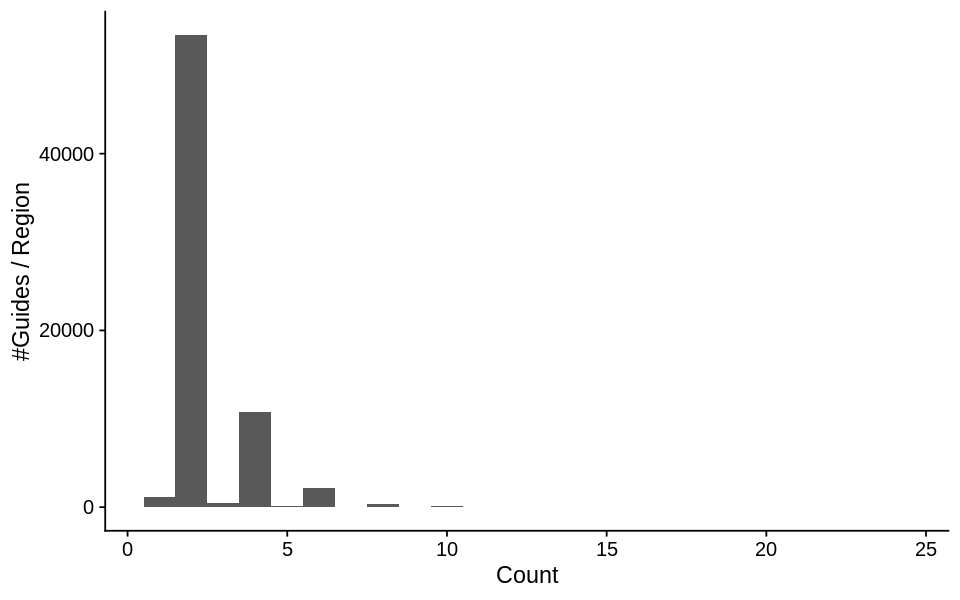

In [13]:
dat = dat_peak_score_summary
gpt = ggplot(dat, aes(x=Count)) + 
    geom_histogram(binwidth = 1) + 
    labs(y="#Guides / Region") +
    theme_cowplot()
options(repr.plot.height=5, repr.plot.width=8)
print(gpt)

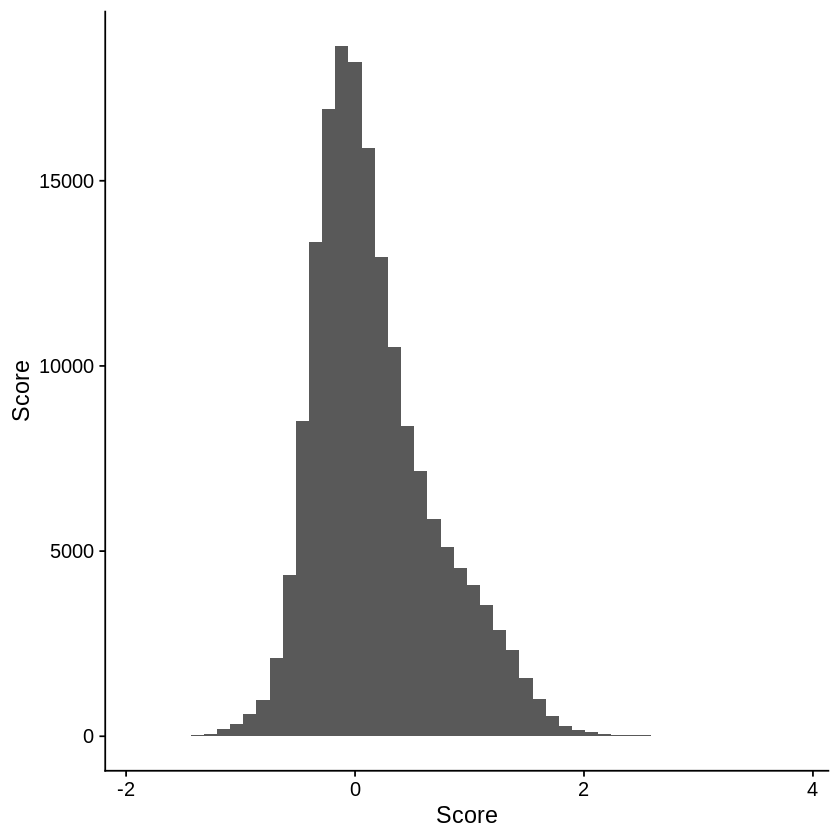

In [10]:
dat = dat_peak_score_arrange
gpt = ggplot(dat, aes(x=Score)) + 
    geom_histogram(bins = 50) + 
    labs(y="Score") +
    theme_cowplot()
print(gpt)

## Save results

In [14]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.score.ENCSR382BVV.ENCFF348WYK.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_arrange
write_tsv(dat, fpath)

In [15]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.summary.ENCSR382BVV.ENCFF348WYK.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_summary
write_tsv(dat, fpath)